In [12]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

In [3]:
def preprocess(X_batch, y_batch):
    X_batch = tf.strings.substr(X_batch, 0, 300)
    X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
    X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
    X_batch = tf.strings.split(X_batch)
    return X_batch.to_tensor(default_value=b"<pad>"), y_batch


In [4]:
from collections import Counter
vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
    for review in X_batch:
        vocabulary.update(list(review.numpy()))

vocabulary.most_common()[:3]

[(b'<pad>', 214309), (b'the', 61137), (b'a', 38564)]

In [5]:
vocab_size = 10000
truncated_vocabulary = [
    word for word, count in vocabulary.most_common()[:vocab_size]]

In [6]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [7]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]], dtype=int64)>

In [8]:
def encode_words(X_batch, y_batch):
 return table.lookup(X_batch), y_batch
train_set = datasets["train"].batch(32).map(preprocess)
train_set = train_set.map(encode_words).prefetch(1)


In [9]:
embed_size = 128
model = keras.models.Sequential([
    keras.layers.Embedding(vocab_size + num_oov_buckets, embed_size,
    input_shape=[None]),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.GRU(128),
    keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="adam",
    metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

c:\Users\maxmi\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 101s 124ms/step - accuracy: 0.5348 - loss: 0.6775
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 130ms/step - accuracy: 0.7884 - loss: 0.4567
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 133ms/step - accuracy: 0.8698 - loss: 0.3144
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 105s 135ms/step - accuracy: 0.9301 - loss: 0.1918
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 102s 131ms/step - accuracy: 0.9526 - loss: 0.1414


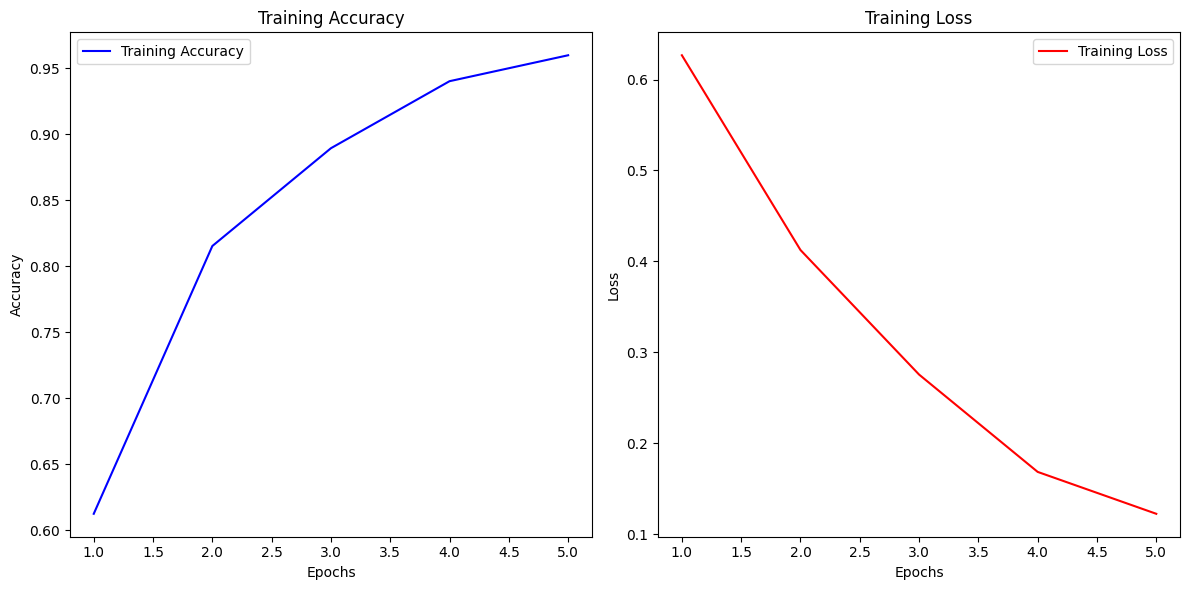

In [15]:
# Angenommen, `history` ist das zurückgegebene Objekt von `model.fit`
# history = model.fit(train_set, epochs=5)

# Extrahiere die Accuracy-Werte aus dem History-Objekt
accuracy = history.history['accuracy']
loss = history.history['loss']

# Anzahl der Epochen
epochs = range(1, len(accuracy) + 1)

# Erstelle das Plot
plt.figure(figsize=(12, 6))

# Plot für Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot für Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
def preprocess_sentence(sentence):
    sentence = tf.strings.substr(sentence, 0, 300)
    sentence = tf.strings.regex_replace(sentence, b"<br\\s*/?>", b" ")
    sentence = tf.strings.regex_replace(sentence, b"[^a-zA-Z']", b" ")
    sentence = tf.strings.split(sentence)
    return sentence

In [11]:
example_sentence = "This movie was fantastic"

# Preprocessing des Beispielsatzes
def preprocess_sentence(sentence):
    sentence = tf.strings.substr(sentence, 0, 300)
    sentence = tf.strings.regex_replace(sentence, b"<br\\s*/?>", b" ")
    sentence = tf.strings.regex_replace(sentence, b"[^a-zA-Z']", b" ")
    sentence = tf.strings.split(sentence)
    return sentence.to_tensor(default_value=b"<pad>")

# Encodieren des Beispielsatzes
def encode_sentence(sentence):
    preprocessed_sentence = preprocess_sentence(sentence)
    encoded_sentence = table.lookup(preprocessed_sentence)
    return encoded_sentence

# Vorhersage für den Beispielsatz
def predict_sentence(sentence):
    encoded_sentence = encode_sentence(tf.constant([sentence]))
    prediction = model.predict(encoded_sentence)
    return prediction

# Vorhersage für den Beispielhafter Satz
prediction = predict_sentence(example_sentence)

# Ergebnis anzeigen
def ergebnis(input):
    if input>0.5:
        output = 'positive'
    else:
        output = 'negative'
    return output

print(f"Vorhersage für den Satz '{example_sentence}': " + ergebnis(prediction)) 
#print(f"Vorhersage für den Satz '{example_sentence}': {prediction[0][0]:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
Vorhersage für den Satz 'This movie was fantastic': positive
